# Reddit Data Scraping
To make a Reddit Flair classifier first we need to have the data for analysis and then fitting data into model. Inorder to grab the data from the subreddit ```r/india```, I will be using the reddit API. Although earlier I came up with other ideas as well, to scrape.

### Praw (Python reddit API Wrapper)
To start working with praw it, requires that the user should have an active reddit account and knows basic working of reddit.<br>
First set up the reddit api and set up the credentials, we'll be using those to use praw and get submissions<br>
Now use the credentials and set up the praw. use the subreddit attribute to get set the api to fetch submissions from a particular subreddit, here in our case it is ```india```.

Praw provides us to get the submissions sorted in order of ```top```, ```hot```, ```new```, ```rising```. So I will fetch the data from all of these, along with a constraint that there should be no duplicates.

One of the drawback of praw is that the limit to fetch submissions is 1000, so one way is to get 1000 posts from each of sorted data, but there are many duplicates, so at the end the data is not enough for analysis and for training.
    
### Psaw (PushShift API Wrapper)
With psaw I can get the any amount of data. This stores all the reddit submissions as soon as they are pushed onto the reddit wall. But the ratings ans number of upvotes, comments are not updated at realtime.

But with psaw the data fetched is not good, in terms of post's rating and comments as these values are not good at the time of post pushed into the database of pushshift.

In [1]:
# install the required libraries
!pip install praw
!pip install psaw

^C


In [0]:
import praw
from praw import models
import pandas as pd
from tqdm.notebook import tqdm
from psaw import PushshiftAPI
import pandas as pd

In [0]:
handle = 'india'
# setting up praw with reddit api
reddit = praw.Reddit(client_id = 'k2akqxbdeejOWw',
                     username='OptimalAdvantage213',
                     client_secret='fZtXNfuqoOv9LSjUZVEMO2vY2wc',
                     password='HelloWorld2112',
                     user_agent='Scrapper')
subreddit = reddit.subreddit(handle)

# checking for all the available flair categories on the subreddit
flair_links = subreddit.flair.link_templates
# all the flairs are stored in flairs list.
flairs = [f['text']for f in flair_links]
flairs

array(['Coronavirus', 'Announcement', 'Non-Political', 'Politics',
        'Policy/Economy', None, 'Photography', 'Food', 'AskIndia',
        'Scheduled', 'Business/Finance', 'Science/Technology',
        'CAA-NRC-NPR', 'Unverified', 'Unverified - Opinion', 'Sports',
        '[R]eddiquette', '/r/all', 'r/all', 'Politics [Megathread]',
        'Totally real', 'CAA-NRC', 'Zoke Tyme', 'Official Sadness Thread',
        'Demonetization', 'Politics -- Source in comments',
        'Policy & Economy', 'Policy/Economy -2017 Article ',
        'Original Comics', 'Misleading Headline ', 'OC', 'Misleading',
        'On Internet Shutdowns', 'Lifehacks', 'AMA', 'Entertainment',
        '40 Martyrs', 'Goal Achieved!!!'], dtype=object)

Here the number of flair categories are quite large. But earlier on scraping data without any flair reference, I ended up with unbalanced data with the flair category, As there are supposed to be more posts related to ```Coronavirus```, ```Politics```, ```Non-Political``` due to the pandemic.
 So now to get a good balanced data, I will be scraping posts only of following 9 flairs,
 1. Coronavirus
 2. Politics
 3. Non-Political
 4. AskIndia
 5. Business/Finance
 6. Policy/Economy
 7. Photography
 8. Food
 9. Science/Technology

### Scrapper Class 
A Scrapper class provides functionality to scrape data from any reddit handle(subreddit)

In [0]:
class Scrapper:
    """
    A Scrapper class to scrape data from any reddit handle(subreddit)
    """
    def __init__(self, handle):
        """
        Args:
            handle (str): subreddit
        """
        self.reddit = praw.Reddit(client_id = 'k2akqxbdeejOWw',
                                  client_secret = 'fZtXNfuqoOv9LSjUZVEMO2vY2wc',
                                  user_agent = 'Scrapper')
        self.handle = handle
        self.Ids = []
        
        
    def getComments(self, ID):
        """
        extracts 'best' 10 comments, including only one comment after expanding 
        more-comments section(where-ever occurs), on given post
        Args:
            ID: id of the post
        return :
            top 10 comments as a single text structure
        """
        submission = self.reddit.submission(id = ID)
        count = 0
        comments = ""
        
        # here limit=1 means for comments having any reply, pick the
        # first reply also along with the head comment
        submission.comments.replace_more(limit=1)
        for head_comments in submission.comments:
            comments+=(" "+head_comments.body)
            count+=1
            if count == 10:
                break;
        return comments[1:]
    
        
    def updateIds(self, n, Flairs):
        """
        updates the Ids of the posts to be scraped using given 'Flairs'
        As the post id is unique, and I will use these ids with praw to get the submissions
        Args:
            n (int): number of reddit posts for each flair in 'Flairs' to be scraped
            Flairs (list): list of all the flairs which are to be considered for scraping
        """
        pshift = PushshiftAPI(self.reddit)
        # get all the submissions from given subreddit with a limit of n*25
        # the limit is kept high because in this span all the posts will be read but only those
        # posts will be considered whose flair is present in the flair list
        gen = pshift.search_submissions(subreddit=self.handle, limit=n*25)
        
        # dictionary of flairs with key as flair name and value as number of posts
        # remaining to be scraped
        flairs = {f:n for f in Flairs}
        pbar = tqdm(gen, total=n*len(Flairs), leave=False)
        for id in pbar:
            pbar.set_description('Fetching Ids..')
            # scrape the posts based on flairs present in the dictionary
            if id.link_flair_text in flairs:
              self.Ids.append(id)
              flairs[id.link_flair_text]-=1
              
              # if the value of any flair has reached zero that means no need to scrape posts of that flair
              # So we will remove the flair from the dictionary
              if flairs[id.link_flair_text]==0 :
                flairs.pop(id.link_flair_text)
                
                # if the dictionary is empty 
                if not bool(flairs):
                  return
        # if the dict is empty(posts of desired flair and of desired amount has been scraped) -> return
        # or if the upper limit here n*25 has reached -> return
    
    
    def scrape(self, n, Flairs):
        """
        main function to scrape data
        Args:
            n (int): number of reddit posts in data to be scraped
            Flairs (list): list of all the flairs which are to be considered for scraping
        Return:
            data (dict): dictionary of data scraped
                         `key`             `value` (list)
                    Id              :(str)(timestamp) post id
                    PostUploadTime  :(str) time of post upload
                    Headline        :(str) post headline
                    Rating          :(int) total of likes and dislikes on post
                    Flair           :(str) flair (tag) of the post
                    PostSource      :(str) link of the reddit post
                    NumComments     :(int) number of comments on the post
                    Comments        :(str) 'best' 10 comments on the post
                    PostBody        :(str) text segment or description part 
                                           of the post(in case of images body is null)
                    UserName        :(str) author of the post
                    UserPostKarma   :(str) post karma of user
                    UserCommentKarma:(str) comment karma of user
        """
        
        self.updateIds(n, Flairs)
        print(len(self.Ids))
        data = {"PostUploadTime": [],
                "Headline":[],
                "Flair":[],
                "Rating":[],
                "UserName": [],
                "UserPostKarma": [],
                "UserCommentKarma": [],
                "Id":[],
                "PostSource":[],
                "NumComments": [],
                "Comments": [],
                "PostBody":[]}
        print('Fetching Data...')
        for id in tqdm(self.Ids, total = len(self.Ids), leave=False):
            try:
                info = models.Submission(self.reddit, id)
            except:
                continue
            # check if current post is already in data
            if info.id in data['Id']:
                continue
            # post info
            data['Id'].append(id)
            data['Headline'].append(info.title)
            data['Flair'].append(info.link_flair_text)
            data['Rating'].append(info.score)
            data['NumComments'].append(info.num_comments)
            data['Comments'].append(self.getComments(info.id))
            data['PostBody'].append(info.selftext)
            data['PostSource'].append(info.url)
            data['PostUploadTime'].append(info.created)

            # user(redditor) info
            data['UserName'].append(info.author)
            # incase of deletion of accounts info.author -> None
            try:
                user = models.Redditor(self.reddit, info.author)
                data['UserPostKarma'].append(user.link_karma)
                data['UserCommentKarma'].append(user.comment_karma)
            except:
                data['UserPostKarma'].append("")
                data['UserCommentKarma'].append("")
                
        return data

In [0]:
handle = 'india'
# initializing Scrapper class
scrp = Scrapper(handle)

In [0]:
# desired flairs
flairs=['Politics',
        'Non-Political',
        'Policy/Economy',
        'Business/Finance',
        'Science/Technology',
        'Sports',
        'Food',
        'Photography',
        'Coronavirus']
n=4000

In [0]:
data_final = scrp.scrape(n, flairs)

17653
Fetching Data...


***Save*** the scraped data in a csv file

In [0]:
# converting the dictionary to pandas dataframe object
df_final = pd.DataFrame(data_final)
# saving the dataframe as a csv file
df_final.to_csv('data_final.csv', index=False)

In [0]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


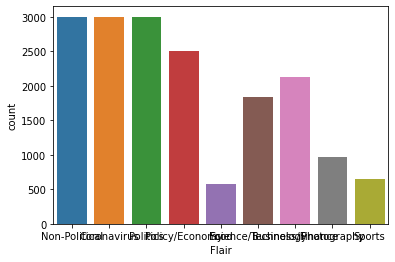

In [0]:
# plotting the number of posts scraped of a flair
sns.countplot(x='Flair', data=df_final)

Although the current data is not good in terms of balanced category, it is good in comparison to all previous data acquired 

In [0]:
df_final.head(13)

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
0,1.587106e+09,Man Arrested For Allegedly Spitting On Manipur...,Non-Political,111,ReallyRedditLover,1008,116,g2ph3l,https://www.ndtv.com/mumbai-news/man-arrested-...,7,">The accused was identified as **Amir Khan** ,...",
1,1.587106e+09,Bought air tickets during lockdown? Full refun...,Coronavirus,8,ReallyRedditLover,1008,116,g2pg1d,https://timesofindia.indiatimes.com/business/i...,2,"So, If I booked the ticket on 21st for 26th Ma...",
2,1.587105e+09,Bollywood Nazis: A Tale of Two Sisters,Politics,19,iSalaamU,32174,14938,g2pd5o,https://www.reddit.com/r/india/comments/g2pd5o...,7,Woah so permanent ban right ? Not temporary .....,"Yesterday, Twitter permanently suspended the a..."
3,1.587105e+09,"On this occasion of Rongāli bihu, I'd love to ...",Non-Political,10,deboo117,8370,2700,g2p97t,https://open.spotify.com/playlist/21uBCM64wmKV...,0,,
4,1.587104e+09,A Tweet Asking For Muslims And Journalists To ...,Coronavirus,1,None,,,g2ovv5,https://www.buzzfeednews.com/article/pranavdix...,1,,[deleted]
5,1.587103e+09,What is your problem with RSS?,Politics,25,meghdooot,17,0,g2oqtr,https://www.reddit.com/r/india/comments/g2oqtr...,21,"Keep reading bunch of thoughts, it has enough ...",Here for a healthy discussion! \nIt's a humble...
6,1.587102e+09,Police Officer feeding an amputee Monkey. ( Or...,Coronavirus,3530,imaraidyoass,7834,1936,g2oda0,https://gfycat.com/pettyanotheranhinga,89,"Raja aur Rancho this world has everything, it ...",
7,1.587102e+09,Should I really be scared of the delivery exec...,Coronavirus,7,CCLasagana,57,1013,g2obqh,https://www.reddit.com/r/india/comments/g2obqh...,4,You need to know how your local grocery does t...,I guess its kind of a CMV. I was thinking abou...
8,1.587101e+09,[R] India and the Nations: A hypothesis that t...,Policy/Economy,0,thedowcast,1036,-4,g2o39t,https://www.reddit.com/r/india/comments/g2o39t...,2,You forgot the /s dude. Wtf did i just read,[removed]
9,1.587101e+09,"Current state of CSMIA, Mumbai",Coronavirus,6,None,,,g2o1ww,https://i.imgur.com/LRFZ9BH.jpg,5,And here I thought photography at airport is i...,[deleted]


In [0]:
df_final.tail()

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
17648,1.573906e+09,I somewhat understand where the government is ...,Policy/Economy,2,None,,,dx1zup,https://www.msn.com/en-in/news/newsindia/in-an...,1,It is not difficult to understand that any dec...,[deleted]
17649,1.573906e+09,[OC] Low effort meme,Food,8,None,,,dx1wdj,https://i.redd.it/kvm3jgby1zy31.jpg,1,Pudine jaisa dikhta hai but pudina nai.,[deleted]
17650,1.573905e+09,People getting married shows economy is fine: ...,Business/Finance,50,banguru,29227,14331,dx1qxn,https://www.deccanherald.com/amp/national/nati...,12,"Sure, it's not like they're making alliances t...",
17651,1.573905e+09,Pollution in Delhi: Residents flock to an ‘oxy...,Science/Technology,32,banguru,29227,14331,dx1pv9,https://amp.scroll.in/article/943857/as-delhi-...,6,Oxygen bar is useless and more or less a gimmi...,
17652,1.573901e+09,Live Concert - This is how we overcome - Hillsong,Photography,1,ravikumarpediredla,316,29,dx13ev,https://i.redd.it/krhxa44soyy31.jpg,0,,


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17653 entries, 0 to 17652
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PostUploadTime    17653 non-null  float64
 1   Headline          17653 non-null  object 
 2   Flair             17653 non-null  object 
 3   Rating            17653 non-null  int64  
 4   UserName          14307 non-null  object 
 5   UserPostKarma     17653 non-null  object 
 6   UserCommentKarma  17653 non-null  object 
 7   Id                17653 non-null  object 
 8   PostSource        17653 non-null  object 
 9   NumComments       17653 non-null  int64  
 10  Comments          17653 non-null  object 
 11  PostBody          17653 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 1.6+ MB


***-> Checking PostBody***

In [0]:
df_final['PostBody'].unique()

array(['',
       'Yesterday, Twitter permanently suspended the account of Rangoli Chandel, Kangana Ranaut\'s sister and manager, for a tweet that was too hateful even for Twitter, the single largest enabler of hate speech after Facebook and Whatsapp.\n\nFollowing is the text of the tweet, verbatim:\n\n"A Jamati died of Corona when police and doctors went to check their families they were attacked and killed, make these mullas + secular media stand in a line and shoot them dead... F**k history. They may call us Nazis who cares, life is more important than fake image." [1]\n\nRangoli Chandel was followed on Twitter by over 100 thousand people. The tweet remained for everyone to see for almost a whole day. It was retweeted 1497 times and liked by over 5600 people.\n\nLast year, in the wake of the Pulwama attack, Kangana Ranaut had said this of Shabana Azmi and Pakistan:\n\n"The film industry is full of such anti-nationals who boost enemies\' morals in many ways, but right now is the time

***->*** In postBody many posts has body as [removed], or null string "", so these are to be replaced by NaN values

In [0]:
for i in range(len(data_final['PostBody'])):
  if data_final['PostBody'] in ["", '[removed]']:
    data_final['PostBody'][i] = 'NaN'

In [0]:
data_final.keys()

dict_keys(['PostUploadTime', 'Headline', 'Flair', 'Rating', 'UserName', 'UserPostKarma', 'UserCommentKarma', 'Id', 'PostSource', 'NumComments', 'Comments', 'PostBody'])

***-> Checking UserName***<br>
In username some posts has no username, bcoz may be the acount has been removed at the time of data fetching so I have to give them nan value

In [0]:
for i in range(len(data_final['UserName'])):
  if data_final['UserName'][i]==None:
    data_final['UserName'][i]='NaN'

***-> Checking Flair***

In [0]:
data_final['Flair']

['Food',
 'Non-Political',
 'Non-Political',
 'Non-Political',
 'Coronavirus',
 'Sports',
 'Coronavirus',
 'Non-Political',
 'Non-Political',
 'Policy/Economy',
 'Coronavirus',
 'Coronavirus',
 'Non-Political',
 'Coronavirus',
 'Politics',
 'Politics',
 'Non-Political',
 'Politics',
 'Non-Political',
 'Non-Political',
 'Non-Political',
 'Non-Political',
 'Policy/Economy',
 'Photography',
 'Sports',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Politics',
 'Photography',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Food',
 'Non-Political',
 'Non-Political',
 'Coronavirus',
 'Politics',
 'Coronavirus',
 'Science/Technology',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Politics',
 'Politics',
 'Politics',
 'Coronavirus',
 'Politics',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'Non-Political',
 'Coronavirus',
 'Non-Political',
 'Politics',
 'Coronavirus',
 'Coronavirus',
 'Coronavirus',
 'N

***-> Checking Comments***

In [0]:
data_final['Comments']

[">The accused was identified as **Amir Khan** , resident of Kurla (West).\n\nShow his photo too so that whole nation can see. he should be flogged in public.. in any case we as a society are bigots and racists.... it's time stricter laws were put in place for incidents like these Well people should spit on him as well ... But may be thats his kink. This feels like same news being posted again and again since more than a month, but actually these are all different cases and different people. Definitely /r/ChutiyonKiFauj a random person spat on me once while walking on the road and i was feeling so disgusted till i reached home, imagine being spat On due to a racist remark, no one thinks what it is to be the other guy",
 'So, If I booked the ticket on 21st for 26th March am I in for the refund ?',
 "Woah so permanent ban right ? Not temporary .. atleast that's good. [1] https://www.buzzfeednews.com/article/pranavdixit/coronavirus-india-twitter-kangana-ranaut-rangoli-chandel\n\n[2] https

In [0]:
for i in range(len(data_final['Comments'])):
  if data_final['Comments'][i]=="":
    data_final['Comments'][i] = 'NaN'

-> Checking UserPostkarma and UserCommentkarma

In [0]:
data_final['UserPostKarma'], data_final['UserCommentKarma']

([260,
  '',
  576,
  1,
  '',
  '',
  6473,
  102922,
  63944,
  8,
  3752,
  180,
  '',
  489,
  224,
  '',
  447,
  762,
  127615,
  '',
  '',
  '',
  35,
  2093,
  35,
  11943,
  39,
  1,
  35,
  657,
  '',
  2655,
  32,
  39,
  35,
  127,
  509,
  '',
  '',
  15760,
  59369,
  1,
  7926,
  7926,
  2129,
  7926,
  '',
  30672,
  14200,
  206734,
  308,
  10787,
  '',
  32645,
  1,
  1045,
  79490,
  431,
  32200,
  20036,
  1,
  37,
  1811,
  1,
  63086,
  32645,
  18764,
  8237,
  19331,
  31,
  2588,
  '',
  63087,
  507,
  1,
  717,
  59,
  5304,
  1661,
  '',
  360,
  206734,
  41,
  '',
  32645,
  180,
  98,
  34,
  745,
  '',
  1075,
  1,
  2655,
  1207,
  '',
  '',
  292,
  '',
  24801,
  224,
  9671,
  2199,
  3978,
  8976,
  166611,
  '',
  343,
  39842,
  15760,
  '',
  '',
  7927,
  '',
  '',
  826,
  8976,
  5,
  4968,
  4504,
  4869,
  '',
  104,
  16290,
  '',
  412,
  2884,
  864,
  3956,
  7251,
  '',
  '',
  '',
  17041,
  1408,
  '',
  6650,
  6650,
  34344,
  16,

In [0]:
# replacing null string with NAN
for i in range(len(data_final['UserPostKarma'])):
  if data_final['UserPostKarma'][i]=='':
    data_final['UserPostKarma'][i] = 'NaN'
  if data_final['UserCommentKarma'][i]=='':
    data_final['UserCommentKarma'][i] = 'NaN'

-> Checking ID<br>
as type of 'id' column is submission type , so i have to convert it to string

In [0]:
data_final['Id']

[Submission(id='fzk8mf'),
 Submission(id='fzk7j5'),
 Submission(id='fzk4se'),
 Submission(id='fzk3jl'),
 Submission(id='fzjykk'),
 Submission(id='fzjtau'),
 Submission(id='fzjq66'),
 Submission(id='fzjkwe'),
 Submission(id='fzjke4'),
 Submission(id='fzjgas'),
 Submission(id='fzjd8h'),
 Submission(id='fzjbvp'),
 Submission(id='fzj5vj'),
 Submission(id='fziwkc'),
 Submission(id='fzio4a'),
 Submission(id='fzilln'),
 Submission(id='fzi10b'),
 Submission(id='fzh1yi'),
 Submission(id='fzgusd'),
 Submission(id='fzgdwa'),
 Submission(id='fzfmzh'),
 Submission(id='fzfm23'),
 Submission(id='fzfkko'),
 Submission(id='fzfcua'),
 Submission(id='fzf5n0'),
 Submission(id='fzf3kp'),
 Submission(id='fzeve9'),
 Submission(id='fzet63'),
 Submission(id='fzeq8j'),
 Submission(id='fzel0n'),
 Submission(id='fzed99'),
 Submission(id='fzebuy'),
 Submission(id='fze76u'),
 Submission(id='fze5re'),
 Submission(id='fze1vh'),
 Submission(id='fzdoqo'),
 Submission(id='fzdm3n'),
 Submission(id='fzdbsw'),
 Submission(

In [0]:
data_final['Id'] = [data_final['Id'][i].id for i in range(len(data_final['Id']))]

##  Saving the final data into a csv

In [0]:
df_final = pd.DataFrame(data_final)
df_final.to_csv('data_final.csv', index=False)